In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math as m
import os

from scipy.stats import gaussian_kde

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda


In [2]:
ROOT_DIR = os.getcwd()
ROOT_DIR

'C:\\Users\\HK Joshi\\Documents\\Github\\major_project\\biocube'

## Generate template using Infinity cube

In [3]:
def infinte_cube(img):
    ''' Perform atomic operations on image similar to infinity cube. On performing these steps 'n' times, we can generate the biometric template.
        Input:
            img: The input image
        Output:
            returns the image after performing atomic operation once
    '''
    # Make width dimension even, if it is not
    if img.shape[1]%2 != 0:
        img = img[:, 0:img.shape[1]-1, :]    

    # Expand horizontally
    new_img = cv2.resize(img, (2*img.shape[1], img.shape[0]))

    # Make the height and width of even number
    if new_img.shape[0]%2 != 0:
        new_img = new_img[0:-2, :, :]
    if new_img.shape[1]%2 != 0:
        new_img = new_img[:, 0:-2, :]
#     plt.imshow(new_img)
#     plt.show()
#     new_img.shape

    # Split image vertically into top image and bottom image
    height, width, channels = new_img.shape
    half_height = height//2

    top_img, bottom_img = new_img[:half_height, :], new_img[half_height:, :]

#     plt.imshow(top_img)
#     plt.show()
#     plt.imshow(bottom_img)
#     plt.show()
#     top_img.shape, bottom_img.shape

    # Perform XOR operation between top and bottom section of images
    XOR_img = np.bitwise_xor(top_img, bottom_img)

#     plt.imshow(XOR_img)

    # Split image into 4 equal parts
    height, width, channels = XOR_img.shape
    quarter_width = width//4
    if width%4 != 0:
        quarter_width = int(width//4)
        XOR_img = XOR_img[:, 1:XOR_img.shape[1]-1, :]

    img1, img2, img3, img4 = XOR_img[:, 0:quarter_width], XOR_img[:, quarter_width: 2*quarter_width], XOR_img[:, 2*quarter_width:3*quarter_width], XOR_img[:, 3*quarter_width:]

#     plt.imshow(img1)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()

    # Create new top and bottom images by merging middle two images and two outermost images respectively 
    top_img = cv2.hconcat([img2, img3])
    bottom_img = cv2.hconcat([img1, img4])

#     plt.imshow(top_img)
#     plt.show()
#     plt.imshow(bottom_img)
#     plt.show()
    
    # Form the image of originaly shape by concatenating the two images vertically
#     print(top_img.shape)
#     print(bottom_img.shape)
    new_img = cv2.vconcat([top_img, bottom_img])

#     plt.imshow(new_img)
#     new_img.shape
    
    # Expand vertically
    new_img = cv2.resize(new_img, (new_img.shape[1], 2*new_img.shape[0]))

#     plt.imshow(new_img)
#     plt.show()
#     new_img.shape

    # Split image horizontally into left image and right image
    height, width, channels = new_img.shape
    half_width = width//2

    left_img, right_img = new_img[:, :half_width], new_img[:, half_width:]

#     plt.imshow(left_img)
#     plt.show()
#     plt.imshow(right_img)
#     plt.show()
#     left_img.shape, right_img.shape

    # Perform XOR operation between left and right section of images
    XOR_img = np.bitwise_xor(left_img, right_img)

#     plt.imshow(XOR_img)

    # Split image into 4 equal parts
    height, width, channels = XOR_img.shape
    quarter_height = height//4

    img1, img2, img3, img4 = XOR_img[0:quarter_height, :], XOR_img[quarter_height:2*quarter_height, :], XOR_img[2*quarter_height:3*quarter_height, :], XOR_img[3*quarter_height:, :]

#     plt.imshow(img1)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()

    # Create new left and right images by merging middle two images and two outermost images respectively 
    left_img = cv2.vconcat([img2, img3])
    right_img = cv2.vconcat([img1, img4])

#     plt.imshow(left_img)
#     plt.show()
#     plt.imshow(right_img)
#     plt.show()

    # Form the image of originaly shape by concatenating the two images vertically
    new_img = cv2.hconcat([left_img, right_img])
#     plt.imshow(new_img)
#     new_img.shape

    return new_img

# Generate template for a given image
def inf_cube_with_itr(icwi_img, iterations):
    ''' Create a template for the given image with specified number of iterations
        Input:
            icwi_img: an image for which we want to generate the template
            iterations: the nuber of times we want to perform infinty cube transforamtions to generate the tempalte
        Output:
            returns the generated template for the given input image
    '''
    icwi_template = icwi_img.copy()
    for _ in range(iterations):
        icwi_template = infinte_cube(icwi_template)
    return icwi_template


# Generate tempalte for whole batch at once
def gen_batch_template(gbt_imgs):
    ''' Generate a set of templates for the given set of images
        Input:
            gbt_imgs: a list of input images
        Output:
            returns the generated template for every image present in the input set
    '''
    gbt_temp = []
    for gbt_img_temp in gbt_imgs:
        gbt_img_temp = np.array(gbt_img_temp, dtype= 'uint8')
        gbt_img_temp = inf_cube_with_itr(gbt_img_temp, iterations)
        gbt_temp.append(gbt_img_temp)
    return gbt_temp

## Load images from directory

In [4]:
# Read all the dataset from directory
dataset_folder = 'LR-VERA-fingervein'
data_directory = os.path.join(ROOT_DIR, dataset_folder)

In [5]:
images = image_dataset_from_directory(
    data_directory,
    seed=42,
    batch_size=64, # Every dataset has 6 images
    image_size=(250,665),
    label_mode='int',
    shuffle=False
)

Found 1320 files belonging to 220 classes.


## Preprocessing (CLAHE)

In [6]:
clahe_imgs = []
img_labels = []
for imgs, labels in images.take(-1):    
    clahe_img = []
    for img, label in zip(imgs, labels):
        gb_img = np.array(img, dtype='uint8')

        gb_img = cv2.GaussianBlur(gb_img, (3,3), sigmaX=2)
        clahe = cv2.createCLAHE(clipLimit =8.0, tileGridSize=(9,9))

        R, G, B = cv2.split(gb_img)
        CLAHEoutput_R = clahe.apply(R)
        CLAHEoutput_G = clahe.apply(G)
        CLAHEoutput_B = clahe.apply(B)

        cl_img = cv2.merge((CLAHEoutput_R, CLAHEoutput_G, CLAHEoutput_B))

        # clahe_img.append(cl_img)
        clahe_imgs.append(cl_img)
        img_labels.append(label)
    # clahe_imgs.append(np.array(clahe_img))
clahe_imgs = np.array(clahe_imgs)
img_labels = np.array(img_labels)

In [7]:
clahe_imgs.shape, img_labels.shape

((1320, 250, 665, 3), (1320,))

## Template Generation

In [8]:
# Generate template for all images in dataset
temp_images = []
iterations = 10
for img in clahe_imgs:
    batch_temp = inf_cube_with_itr(img, iterations)
    temp_images.append(np.array(batch_temp))

temp_images = np.array(temp_images)

In [9]:
temp_images.shape

(1320, 250, 664, 3)

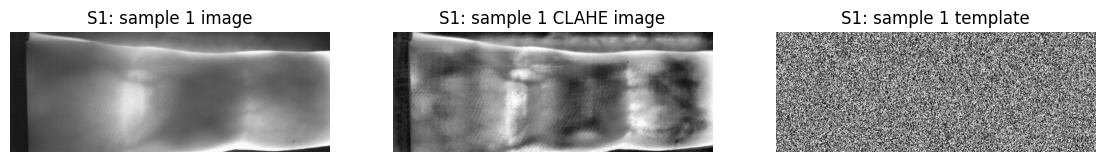

<Figure size 640x480 with 0 Axes>

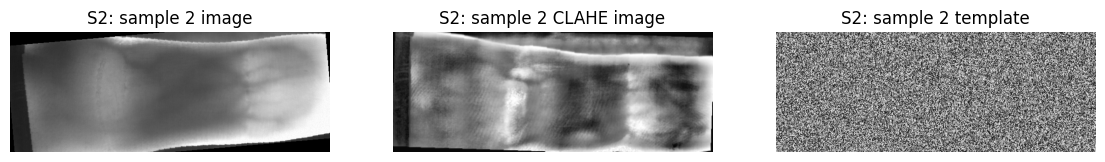

<Figure size 640x480 with 0 Axes>

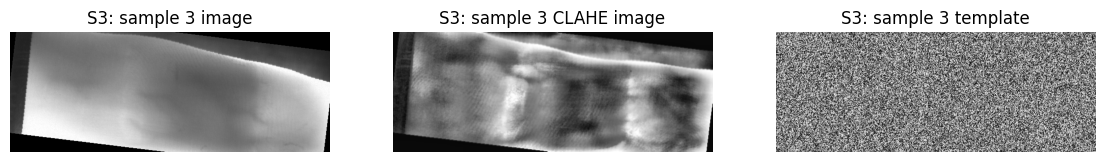

<Figure size 640x480 with 0 Axes>

In [10]:
for ind, imgs in enumerate(images.take(3)):
    plt.figure(figsize=(14,7))

    plt.subplot(131)
    plt.imshow(np.uint8(imgs[0][ind]))
    plt.title(f'S{ind+1}: sample {ind+1} image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(clahe_imgs[ind])
    plt.title(f'S{ind+1}: sample {ind+1} CLAHE image')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(temp_images[ind])
    plt.title(f'S{ind+1}: sample {ind+1} template')
    plt.axis('off')

    plt.show()
    plt.tight_layout()

## Create dataset for NN

In [100]:
train_imgs, val_imgs, test_imgs = [], [], []
train_lbls, val_lbls, test_lbls = [], [], []
zip_data = zip(temp_images, img_labels)
for ind, (temp, lbl) in enumerate(zip_data):
    if ind %6 <= 3:
        train_imgs.append(temp)
        train_lbls.append(lbl)
    elif ind %6 == 4:
        val_imgs.append(temp)
        val_lbls.append(lbl)
    elif ind %6 == 5:
        test_imgs.append(temp)
        test_lbls.append(lbl)

num_of_classes = len(list(images.class_names))
train_lbls = tf.keras.utils.to_categorical(train_lbls, num_classes=num_of_classes)
val_lbls = tf.keras.utils.to_categorical(val_lbls, num_classes=num_of_classes)
test_lbls = tf.keras.utils.to_categorical(test_lbls, num_classes=num_of_classes)

train_imgs, val_imgs, test_imgs = np.asarray(train_imgs), np.asarray(val_imgs), np.asarray(test_imgs)
train_lbls, val_lbls, test_lbls = np.asarray(train_lbls), np.asarray(val_lbls), np.asarray(test_lbls)

In [102]:
train_imgs.shape, val_imgs.shape, test_imgs.shape

((880, 250, 664, 3), (220, 250, 664, 3), (220, 250, 664, 3))

In [103]:
train_lbls.shape, val_lbls.shape, test_lbls.shape

((880, 220), (220, 220), (220, 220))

In [92]:
def small_CNN():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(250, 664, 3)),
        tf.keras.layers.Conv2D(16, (5,5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Conv2D(32, (5,5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(516, activation='relu'),
        tf.keras.layers.Dense(220, activation='softmax')
    ])
    return model

In [93]:
my_CNN = small_CNN()
my_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 246, 660, 16)      1216      
                                                                 
 batch_normalization_6 (Batc  (None, 246, 660, 16)     64        
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 246, 660, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 82, 220, 16)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 216, 32)       12832     
                                                                 
 batch_normalization_7 (Batc  (None, 78, 216, 32)     

In [106]:
my_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = my_CNN.fit(train_imgs, train_lbls, epochs=150, batch_size=16, validation_data=(val_imgs, val_lbls), use_multiprocessing=True, shuffle=True)

Epoch 1/150
55/55 [==============================] - 171s 3s/step - loss: 5.3845 - accuracy: 0.0068 - val_loss: 5.3937 - val_accuracy: 0.0045
Epoch 2/150
55/55 [==============================] - 164s 3s/step - loss: 5.3827 - accuracy: 0.0045 - val_loss: 5.3937 - val_accuracy: 0.0045
Epoch 3/150
55/55 [==============================] - 163s 3s/step - loss: 5.3827 - accuracy: 0.0068 - val_loss: 5.3937 - val_accuracy: 0.0045
Epoch 4/150
55/55 [==============================] - 163s 3s/step - loss: 5.3826 - accuracy: 0.0068 - val_loss: 5.3937 - val_accuracy: 0.0045
Epoch 5/150
55/55 [==============================] - 166s 3s/step - loss: 5.3827 - accuracy: 0.0068 - val_loss: 5.3937 - val_accuracy: 0.0045
Epoch 6/150
55/55 [==============================] - 163s 3s/step - loss: 5.3827 - accuracy: 0.0068 - val_loss: 5.3937 - val_accuracy: 0.0045
Epoch 7/150
55/55 [==============================] - 163s 3s/step - loss: 5.3826 - accuracy: 0.0068 - val_loss: 5.3937 - val_accuracy: 0.0045
Epoch 

KeyboardInterrupt: 